# Supervised Learning on Two Classification Problems

## Get Data: Freddie Mac Mortage Default Predict 

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import itertools
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, learning_curve, validation_curve
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
pd.set_option('display.max_columns', None)

## Data Sets Used

Freddie Mac has created a smaller dataset, which is a random sample of 50,000 loans selected from each full vintage year. Each vintage year has one origination data file and one monthly performance file, containing the same loan-level data fields as those included in the full dataset. We have located the `sample_2016.zip` file from the full dataset package, and used this zip package as our data source for this iteration.

The 2016 zip packages has two files: `sample_orig_2016.txt` and `sample_svcg_2016.txt`. The .txt files do not come with headers but instead, we refer to the User Guide (http://www.freddiemac.com/research/pdf/user_guide.pdf) to grab the name of the columns. We then join the two data files together by the loan number. 

It is expected that as we progressed further, we will be using larger and larger datasets. But for this first iteration, this is what we have chosen.

In [2]:
def get_all_data():
    #dir = 'D:\\Backups\\StemData\\'
    files = ['sample_orig_2016.txt', 'sample_orig_2015.txt', 'sample_orig_2014.txt', 'sample_orig_2013.txt',
             'sample_orig_2012.txt', 'sample_orig_2011.txt',
             'sample_orig_2010.txt', 'sample_orig_2009.txt', 'sample_orig_2008.txt', 'sample_orig_2007.txt']

    files1 = ['sample_svcg_2016.txt', 'sample_svcg_2015.txt', 'sample_svcg_2014.txt', 'sample_svcg_2013.txt',
              'sample_svcg_2012.txt', 'sample_svcg_2011.txt',
              'sample_svcg_2010.txt', 'sample_svcg_2009.txt', 'sample_svcg_2008.txt', 'sample_svcg_2008.txt']

    merged_data = pd.DataFrame()
    for i in [0]:
        print(files[i])
        raw = pd.read_csv(files[i], sep='|', header=None, low_memory=False)
        raw.columns = ['credit_score', 'first_pmt_date', 'first_time', 'mat_date', 'msa', 'mi_perc', 'units',
                       'occ_status', 'ocltv', 'odti', 'oupb', 'oltv', 'oint_rate', 'channel', 'ppm', 'fixed_rate',
                       'state', 'prop_type', 'zip', 'loan_num', 'loan_purpose', 'oterm', 'num_borrowers', 'seller_name',
                       'servicer_name', 'exceed_conform']

        raw1 = pd.read_csv(files1[i], sep='|', header=None, low_memory=False)
        raw1.columns = ['loan_num', 'yearmon', 'curr_upb', 'curr_delinq', 'loan_age', 'remain_months', 'repurchased',
                        'modified', 'zero_bal', 'zero_date', 'curr_rate', 'curr_def_upb', 'ddlpi', 'mi_rec',
                        'net_proceeds',
                        'non_mi_rec', 'exp', 'legal_costs', 'maint_exp', 'tax_insur', 'misc_exp', 'loss', 'mod_exp']

        data = pd.merge(raw, raw1, on='loan_num', how='inner')

        merged_data = merged_data.append(data)

    merged_data.drop(['seller_name', 'servicer_name', 'first_pmt_date', 'mat_date', 'msa', 'net_proceeds'], axis=1, inplace=True)

    # all data must have the following: credit_score, ocltv, odti, oltv, oint_rate, curr_upb
    # remove any datapoints with missing values from the above features
    merged_data.dropna(subset=['credit_score', 'odti', 'oltv', 'oint_rate', 'curr_upb'], how='any', inplace=True)
    merged_data.credit_score = pd.to_numeric(data['credit_score'], errors='coerce')
    merged_data.yearmon = pd.to_datetime(data['yearmon'], format='%Y%m')
    merged_data.fillna(value=0, inplace=True, axis=1)
    
    merged_data.sort_values(['loan_num'], ascending=True).groupby(['yearmon'], as_index=False)  ##consider move this into the next func
    merged_data.set_index(['loan_num', 'yearmon'], inplace=True) ## consider move this into the next func

    return merged_data

## Process Data: Treatment of Missing Values

Key features that are missing are more likely to be the result of reporting errors by the originator or the servicer, or incomplete information provided by the borrower. Similar to the Deep Learning paper we are reading, we have insisted that an observation must have no missing values in any of the following:

* FICO score

* LTV ratio

* Original interest rate

* original balance

Samples missing one of these variables are removed. 

After this step, we still have lots of missing values -- a lot of them came from the performance file (such as loan modification costs, legal expenses, etc). Our treatment so far is to treat the missing values as zero, as an missing value of these fields tend to be due to the fact that there hasn't been such an incidence yet.

It is clear that we will need to fine-tune our current treatment of missing values. This will be done in the second iteration by leveraging research already done by other STEM interns.



## Feature Space

Here, we also model after the Deep Learning for Mortgage Risk paper. In the paper, the authors have enumerated the possible states (current, 30 days delinquent, etc), and together, with other loan_level features (listed in Table 2 and Table 6 in the paper), formed the feature space for their model.

We do similar things here. The following code chunk further process the data: 

* Get the delinquency status that is associated with the loans and last observed month, and add a data column called `prev_delin`, in contrast with `curr_delinq`

* Remove the `curr_delinq` from our features but the feature space still has `prev_delinq` variable

* Use `curr_delinq` as our taget

* For the categorical variables, we convert them into dummy/indicator variables


In [3]:
def process_data(data):
    y = data['curr_delinq']
    y = y.apply(lambda x: 1 if x not in (0, 1) else 0)
    data.fillna(value=0, inplace=True, axis=1)
    data.drop(['curr_delinq'], axis=1, inplace=True)
    print(y.shape)
    X = pd.get_dummies(data)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

## Hyperparameter Grid Search Across Multiple Models in Scikit-learn

In [4]:
def plot_complexity_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=None,
                        n_jobs=1):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.title("Validation Curves")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=10, scoring="roc_auc", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

In [5]:
models = {
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', max_depth=13),
    'NeuralNetwork': MLPClassifier(hidden_layer_sizes=(160)),
    'GradientBoosting': GradientBoostingClassifier(max_depth=1, n_estimators=50),
    'SupportVectorMachine': LinearSVC(class_weight='balanced'),
    'KNearestNeighbor': KNeighborsClassifier(n_neighbors=5)}

In [6]:
params1 = {
    'DecisionTree': {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
    'NeuralNetwork': {'validation_fraction': [0.1, 0.25, 0.33, 0.5, 0.75, 0.9]},
    'GradientBoosting': {'max_depth': [1, 2, 3]},
    'SupportVectorMachine': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'KNearestNeighbor': {'n_neighbors': [3,7,11]}
}

sample_orig_2016.txt
(203642,)
DecisionTree
286.56627678871155


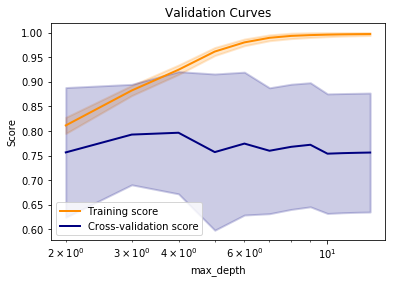

NeuralNetwork
543.0069482326508


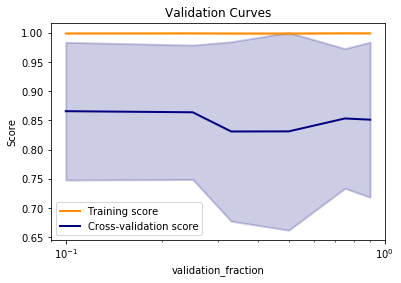

GradientBoosting
1132.9582180976868


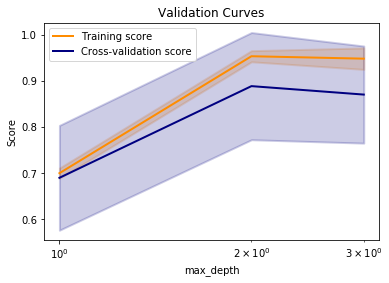

SupportVectorMachine
3504.06165599823


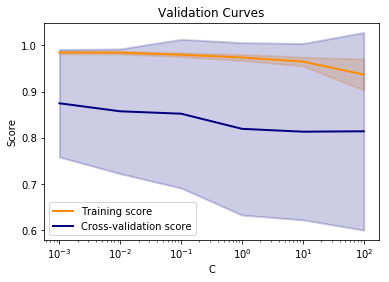

KNearestNeighbor
58639.301841020584


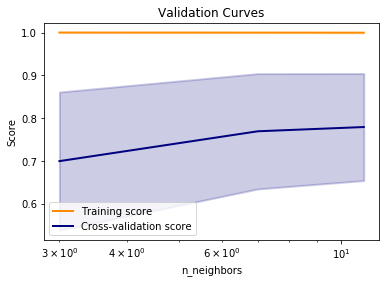

In [7]:
all_data = get_all_data()
train, target = process_data(all_data)
for model in models:
    title = model
    print(title)
    start_time = time()
    plot_complexity_curve(models[model], title, train, target, list(params1[model].keys())[0], 
                          list(params1[model].values())[0], cv=3, n_jobs=-1)
    print(time() - start_time)
    plt.show()

## Learning Curves Study

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

sample_orig_2016.txt
(203642,)
Learning Curves: DecisionTree
17.307898998260498


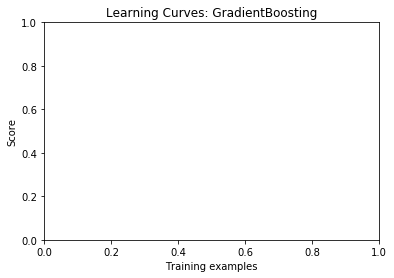

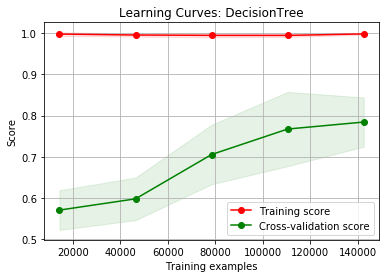

Learning Curves: NeuralNetwork
75.49814295768738


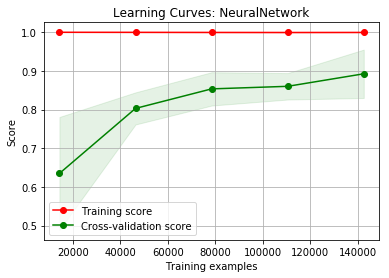

Learning Curves: GradientBoosting
105.41445112228394


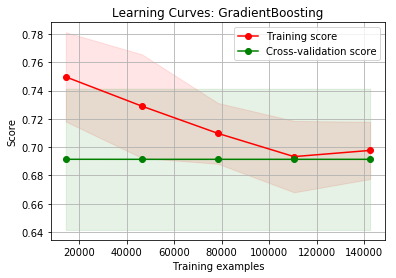

Learning Curves: SupportVectorMachine
137.8297312259674


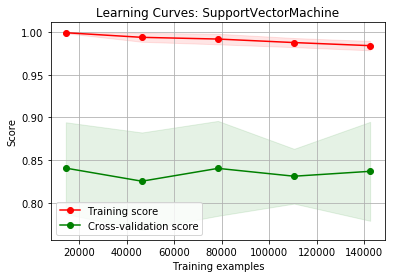

Learning Curves: KNearestNeighbor
13462.186902046204


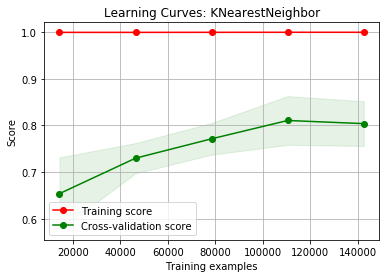

In [10]:
all_data = get_all_data()
train, target = process_data(all_data)
for model in models:
    title = 'Learning Curves: ' + model
    cv = ShuffleSplit(n_splits=5, test_size=0.3)
    print(title)
    start_time = time()
    plot_learning_curve(models[model], title, train, target, cv=cv, n_jobs=-1)
    print(time() - start_time)
    plt.show()

## Get Data: Blood Donation Prediction 

In [11]:
def get_all_data_bloodDonation():
    file = 'train_cleaned.csv'
    data = pd.read_csv(file)

    temp = (data['Months since First Donation'] - data['Months since Last Donation']) / data['Number of Donations']
    temp -= data['Months since Last Donation']
    data['if'] = abs(temp)

    return data



def process_data_bloodDonation(data):
    numerical_features = ['Number of Donations', 'Months since First Donation', 'Months since Last Donation', 'If']

    y = data['Made Donation in March 2007']
    X = data.loc[:, numerical_features]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

## Learning Curve and Complexity Curve Analysis

DecisionTree
0.3312828540802002


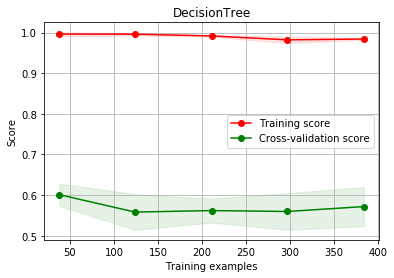

NeuralNetwork


/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anacond

1.7374458312988281


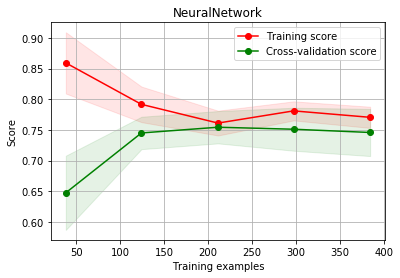

GradientBoosting
0.40455079078674316


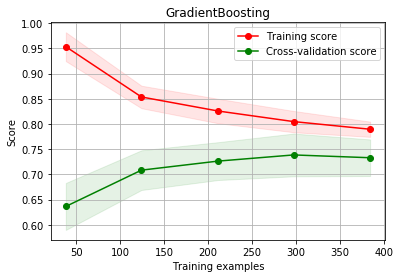

SupportVectorMachine
0.2950749397277832


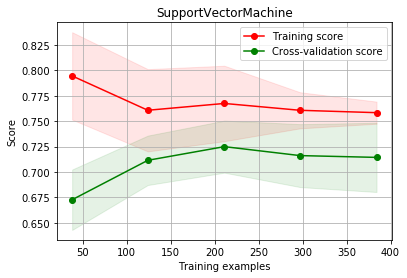

KNearestNeighbor
0.2911970615386963


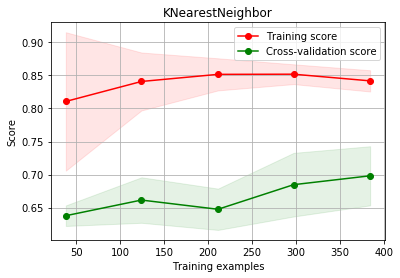

In [12]:
all_data_blood = get_all_data_bloodDonation()
train, target = process_data_bloodDonation(all_data_blood)
for model in models:
    title = model
    cv = ShuffleSplit(n_splits=5, test_size=0.33)
    print(title)
    start_time = time()
    plot_learning_curve(models[model], title, train, target, cv=cv, n_jobs=-1)
    print(time() - start_time)
    plt.show()

DecisionTree
0.4400908946990967


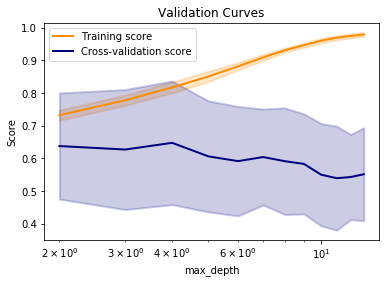

NeuralNetwork
13.484993934631348


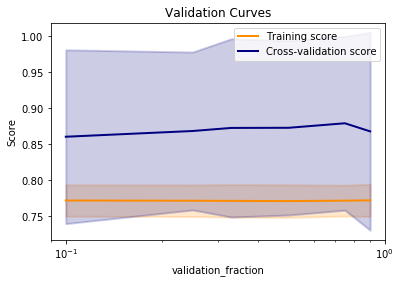

GradientBoosting
0.5564768314361572


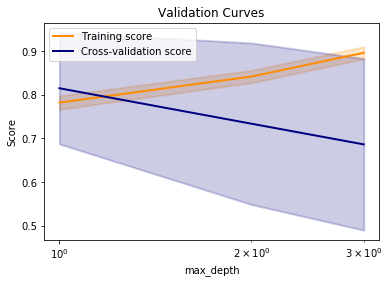

SupportVectorMachine
0.5683979988098145


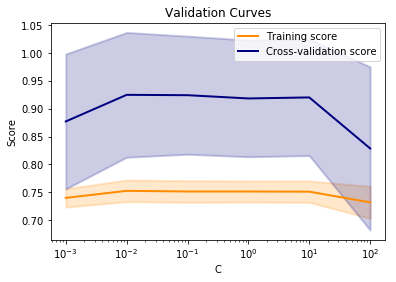

KNearestNeighbor
0.14858603477478027


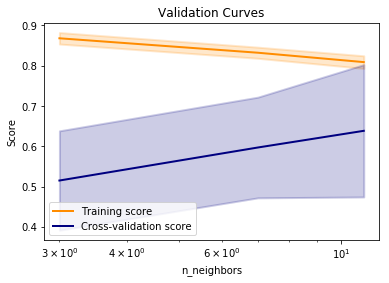

In [13]:
all_data_blood = get_all_data_bloodDonation()
train, target = process_data_bloodDonation(all_data_blood)
for model in models:
    title = model
    cv = ShuffleSplit(n_splits=5, test_size=0.33)
    print(title)
    start_time = time()
    plot_complexity_curve(models[model], title, train, target, list(params1[model].keys())[0], 
                          list(params1[model].values())[0], cv=5, n_jobs=-1)
    print(time() - start_time)
    plt.show()